# Military Aircraft Classification - DenseNet121


O avanço das técnicas de visão computacional e o aumento da disponibilidade de imagens de satélite de alta resolução têm permitido novas aplicações estratégicas no domínio aeroespacial. Entre essas aplicações, a **classificação de modelos de aeronaves militares** emerge como um desafio com relevância para segurança, vigilância, defesa, inteligência e monitoramento estratégico.

Este projeto visa desenvolver um modelo baseado na arquitetura de rede neural DenseNet121 para classificar imagens de aeronaves em **8 classes específicas**: **A10, B1, B2, B52, C17, E3, F22 e U2**. A escolha dessas classes se justifica por sua representatividade em diferentes papéis militares — bombardeiros, aviões de transporte, aeronaves de reconhecimento etc. — e pelo potencial de aplicação em cenários reais de monitoramento e análise de satélite.

### Motivação e relevância

- Em contextos de segurança nacional ou vigilância em zonas de conflito, identificar corretamente o tipo de aeronave a partir de imagens de satélite pode subsidiar decisões rápidas e estratégicas.  
- A classificação precisa é uma etapa crucial antes de tarefas mais especializadas, como detecção de partes danificadas ou tarefas de segmentação para análise detalhada.  
- Dado que imagens de satélite frequentemente apresentam desafios como ruído, variação de ângulo, sombras, escala e condições atmosféricas, escolher uma arquitetura robusta como a EfficientNet pode permitir bom equilíbrio entre desempenho e eficiência computacional.  


Este notebook tem como objetivos:

1. Carregar e pré-processar um dataset de imagens de aeronaves militares, com divisão para treino, validação e teste.  
2. Configurar um modelo **EfficientNet** para classificar nas 8 classes mencionadas.  
3. Treinar o modelo, monitorando métricas como acurácia, loss, precisão/recall por classe.  
4. Avaliar o desempenho em teste, com matriz de confusão, métricas por classe e análise qualitativa de casos de erro.  




## Diretório de trabalho

In [1]:
from google.colab import drive
import os

# Monta o drive no Google Colab
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


<a name='1'></a>
## 1. Importar Pacotes e Funções



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import zipfile
import pandas as pd
import seaborn as sns

In [3]:
from keras.applications.efficientnet_v2 import EfficientNetV2S
from keras.applications.densenet import DenseNet121

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import layers

from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf


In [4]:
print(tf.__version__)

2.19.0


### 1.1 Funções criadas

In [5]:
def plot_test_predictions_random(model, test_ds, class_names, num_images=9, seed=42):
    """
    Plota predições do modelo sobre o conjunto de teste, com imagens randomizadas.
    Acerta em verde, erro em vermelho.

    Args:
        model: modelo treinado
        test_ds: tf.data.Dataset de teste
        class_names: lista de nomes das classes
        num_images: número de imagens a exibir
        seed: semente para randomização
    """
    # Transformar dataset em lista de imagens e labels
    images_list = []
    labels_list = []
    for imgs, lbls in test_ds:
        images_list.append(imgs.numpy())
        labels_list.append(lbls.numpy())
    images_array = np.concatenate(images_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Randomizar índices
    np.random.seed(seed)
    indices = np.random.choice(len(images_array), size=num_images, replace=False)

    plt.figure(figsize=(15, 15))

    for i, idx in enumerate(indices):
        img = images_array[idx]
        true_label = labels_array[idx]

        # Predição
        pred = model.predict(img[np.newaxis, ...])
        pred_label = np.argmax(pred, axis=1)[0]

        # Definir cor do título
        color = 'green' if pred_label == true_label else 'red'

        plt.subplot(int(np.ceil(num_images/3)), 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color=color)

    plt.tight_layout()
    plt.show()


<a name='2'></a>
## 2. Carregar o Dataset




- descompactando o dataset:

In [6]:
import zipfile

# Caminho do arquivo no Drive
zip_path = "/content/drive/MyDrive/AEROESPACIAIS/Aircraft_Dataset.zip"
output_dir = "/content/"

# Descompacta
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Dataset descompactado em: {output_dir}")

Dataset descompactado em: /content/


- Total de imagens:

In [7]:
import pathlib

data_dir = "/content/Aircraft_Dataset"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

4369


- Exemplos:

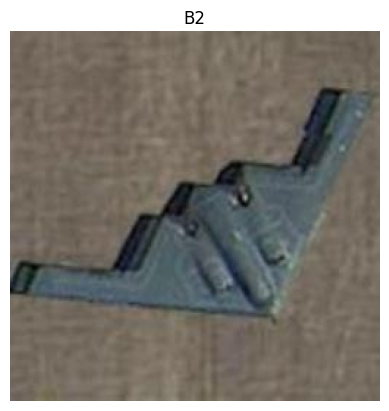

In [8]:
b2 = list(data_dir.glob('B2/*'))
img = plt.imread(b2[0])
plt.imshow(img);
plt.title("B2");
plt.axis('off');

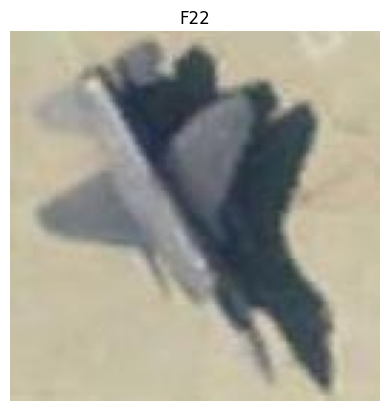

In [9]:
f22 = list(data_dir.glob('F22/*'))
img = plt.imread(f22[0])
plt.imshow(img);
plt.title("F22");
plt.axis('off');

<a name='2-1'></a>
### 2.1 Carregando os Dados


Vamos carregar essas imagens usando `tf.keras.utils.image_dataset_from_directory` .

- parâmetros para o carregador:

In [10]:
batch_size = 32
img_height = 256
img_width = 256

Usaremos 70% das imagens para treinamento, 15% para validação e 15% para testes

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 8 classes.
Using 3059 files for training.


In [12]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4369 files belonging to 8 classes.
Using 1310 files for validation.


In [13]:
# Agora divide val_test_ds em 2 (validação e teste)
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

In [14]:
train_count = tf.data.experimental.cardinality(train_ds).numpy() * 32  # batch_size
val_count = tf.data.experimental.cardinality(val_ds).numpy() * 32
test_count = tf.data.experimental.cardinality(test_ds).numpy() * 32

print(f"Treino: {train_count}, Validação: {val_count}, Teste: {test_count}")


Treino: 3072, Validação: 640, Teste: 672


In [15]:
class_names = train_ds.class_names
print(class_names)

['A10', 'B1', 'B2', 'B52', 'C17', 'E3', 'F22', 'U2']


- visualizando os dados:

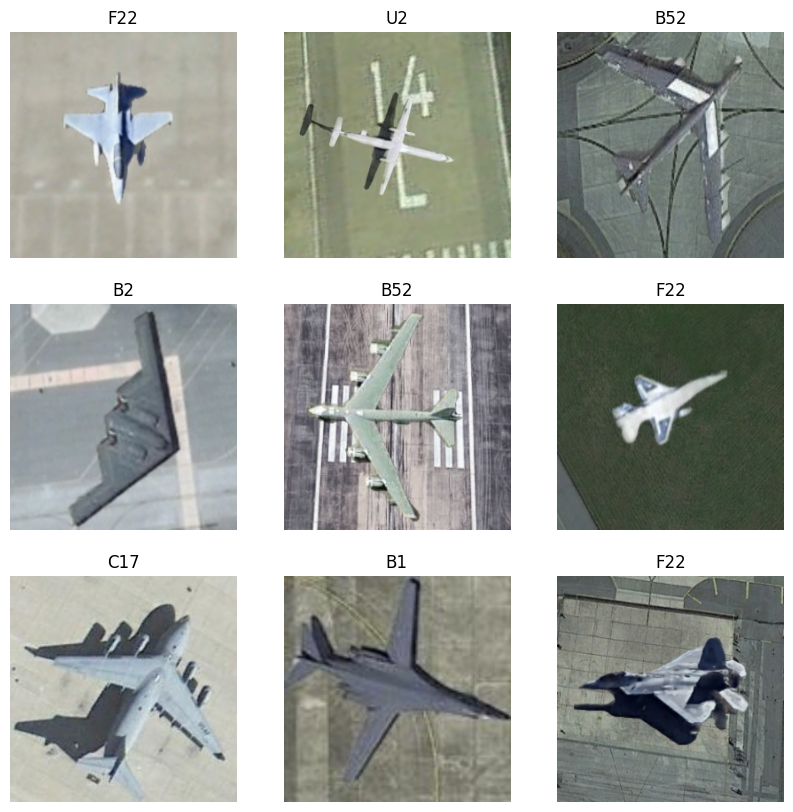

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

<a name='2-3'></a>
### 2.3 Preparando as Imagens

As imagens estão na faixa [0, 255].

Vamos padronizar os valores para estarem no intervalo [0, 1].

In [17]:
img = plt.imread('/content/Aircraft_Dataset/F22/10.jpeg')

In [18]:
img.shape

(249, 290, 3)

In [19]:
np.min(img), np.max(img)

(np.uint8(0), np.uint8(239))

In [20]:
from tensorflow.keras import layers

# Normalização [0, 255] → [0, 1]
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [21]:
for images, labels in train_ds.take(1):
    img = images[0]
    print("Mínimo:", tf.reduce_min(img).numpy())
    print("Máximo:", tf.reduce_max(img).numpy())


Mínimo: 0.082598045
Máximo: 0.78921574


<a name='3'></a>
## 3. Desenvolvimento do Modelo



### 3.1 DenseNet201

A seguir, vamos utilizar o modelo pré-treinado DenseNet201, disponível diretamente na API do Keras.  

Esse modelo foi originalmente treinado no conjunto de dados **ImageNet**, o que permite aproveitar suas representações visuais já aprendidas para acelerar e melhorar o desempenho do nosso treinamento em um conjunto menor e mais específico — neste caso, imagens de aeronaves militares capturadas por satélite.

Para adaptar o DenseNet201 à nossa tarefa de **classificação multiclasse** (com 8 tipos diferentes de aeronaves), adicionamos as seguintes camadas sobre sua base convolucional:

1. Uma camada `GlobalAveragePooling2D`, responsável por condensar as ativações espaciais das últimas camadas convolucionais em um vetor médio, reduzindo a dimensionalidade e mantendo as informações mais relevantes.  
2. Uma camada `Dense` final com ativação `softmax`, que transforma a saída do modelo em uma **distribuição de probabilidade entre as 8 classes possíveis**, onde a soma das probabilidades é igual a 1.

Como nossos rótulos são **inteiros representando as classes** (por exemplo, 0 para A10, 1 para B1, ..., 7 para U2), utilizamos a função de perda **`sparse_categorical_crossentropy`**.  
Essa função é ideal para classificação multiclasse quando os rótulos não estão codificados em formato *one-hot*, simplificando o pipeline de treinamento.



In [22]:
for images, labels in train_ds.take(1):
    print("Shape das imagens:", images.shape)
    print("Shape dos rótulos:", labels.shape)
    print("Exemplo de rótulos:", labels[:5].numpy())


Shape das imagens: (32, 256, 256, 3)
Shape dos rótulos: (32,)
Exemplo de rótulos: [6 7 7 5 1]


In [23]:
!nvidia-smi


Fri Oct 17 15:00:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             28W /   70W |     136MiB /  15360MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
# Número de classes (ex: 8 tipos de aeronaves)
num_classes = 8

# Carrega o modelo base pré-treinado no ImageNet
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Cria a cabeça de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)       # opcional — camada intermediária
x = Dense(num_classes, activation='softmax')(x)  # Softmax para multiclasse

# Define o modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Compilação
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,960 (27.85 MB)

 Trainable params: 7,218,312 (27.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [26]:
# Caminho para salvar os melhores pesos
weight_path = '/content/drive/MyDrive/AEROESPACIAIS/status_best_weights_densenet.weights.h5'

# Callback para salvar os melhores pesos durante o treinamento
checkpointer = ModelCheckpoint(
    filepath=weight_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

# Reduz a taxa de aprendizado quando a validação estabiliza
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    factor=0.7,
    min_lr=1e-5
)

# Interrompe o treinamento se não houver melhora
early = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# Lista final de callbacks
callbacks = [checkpointer, learning_rate_reduction, early]


In [27]:
# Acessar os nomes das camadas
layer_names = [layer.name for layer in model.layers]

# Exibir os nomes das camadas
print(layer_names)

['input_layer', 'zero_padding2d', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'zero_padding2d_1', 'pool1', 'conv2_block1_0_bn', 'conv2_block1_0_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_concat', 'conv2_block2_0_bn', 'conv2_block2_0_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_concat', 'conv2_block3_0_bn', 'conv2_block3_0_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_concat', 'conv2_block4_0_bn', 'conv2_block4_0_relu', 'conv2_block4_1_conv', 'conv2_block4_1_bn', 'conv2_block4_1_relu', 'conv2_block4_2_conv', 'conv2_block4_concat', 'conv2_block5_0_bn', 'conv2_block5_0_relu', 'conv2_block5_1_conv', 'conv2_block5_1_bn', 'conv2_block5_1_relu', 'conv2_block5_2_conv', 'conv2_block5_concat', 'conv2_block6_0_bn', 'conv2_block6_0_relu', 'conv2_block6_1_conv', 'conv2_block6_1_bn', 'conv2_block6_1_relu', '

## 4. Treinamento

Com nosso modelo pronto para treinamento, vamos usar a função `model.fit()` no Keras para treinar nosso modelo.
- Estamos treinando em um pequeno conjunto de dados.
- Portanto, o que nos importa neste momento é garantir que a perda no conjunto de treinamento esteja diminuindo.


In [28]:
%%time

history = model.fit(
    train_ds,             # Dataset de treino
    validation_data=val_ds,  # Dataset de validação
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7800 - loss: 0.6522   
Epoch 1: val_accuracy improved from -inf to 0.42969, saving model to /content/drive/MyDrive/AEROESPACIAIS/status_best_weights_densenet.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.7810 - loss: 0.6494 - val_accuracy: 0.4297 - val_loss: 7.6953 - learning_rate: 0.0010
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9562 - loss: 0.1318
Epoch 2: val_accuracy improved from 0.42969 to 0.66094, saving model to /content/drive/MyDrive/AEROESPACIAIS/status_best_weights_densenet.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.9562 - loss: 0.1318 - val_accuracy: 0.6609 - val_loss: 2.0903 - learning_rate: 0.0010
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9619 - loss: 0.1119
Epoch 3: val_accuracy improved from 0.66094 to 0.88906, saving model to /content/drive/MyDrive/AEROESPACIAIS/status_best_weights_densenet.weights.h5
96/96 ━━━━━━━

In [29]:
!nvidia-smi

Fri Oct 17 15:26:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             45W /   70W |    7342MiB /  15360MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

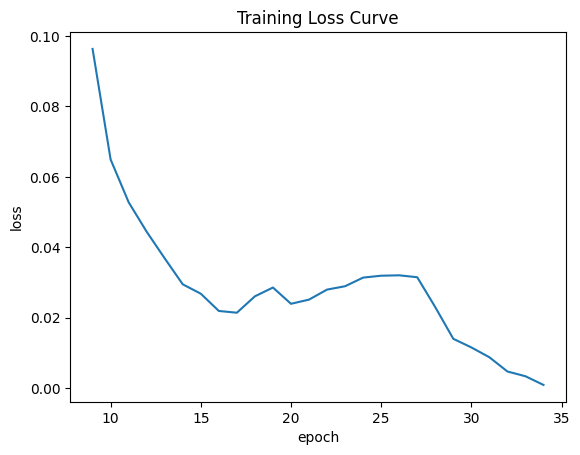

In [30]:
loss = pd.Series(history.history['loss']).rolling(10).mean()

plt.plot( loss )
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

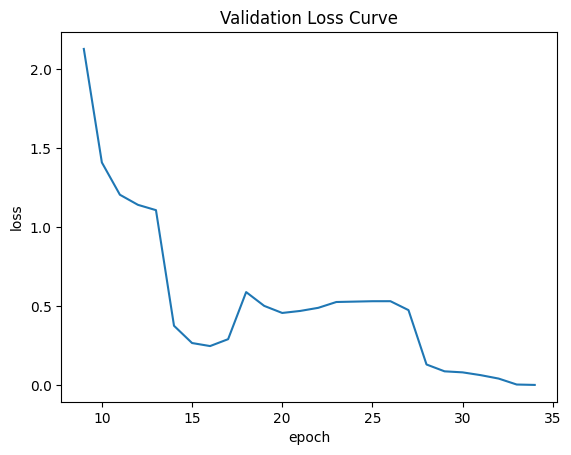

In [31]:
val_loss = pd.Series(history.history['val_loss']).rolling(10).mean()

plt.plot(val_loss)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Validation Loss Curve")
#plt.yscale("log")
plt.show()

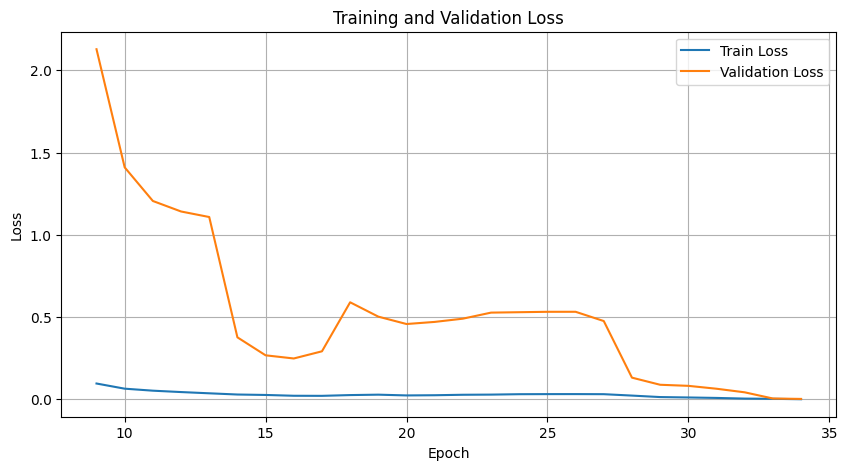

In [32]:
# --- Loss ---
window_size = 10
train_loss = pd.Series(history.history['loss']).rolling(window_size).mean()
val_loss   = pd.Series(history.history['val_loss']).rolling(window_size).mean()

plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

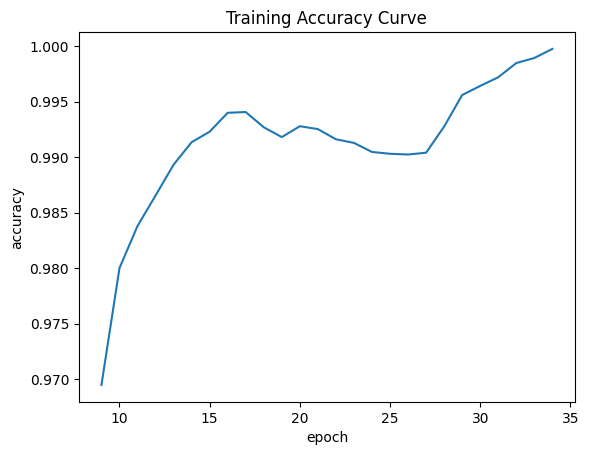

In [33]:
train_acc = pd.Series(history.history['accuracy']).rolling(10).mean()

plt.plot( train_acc )
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Training Accuracy Curve")
plt.show()

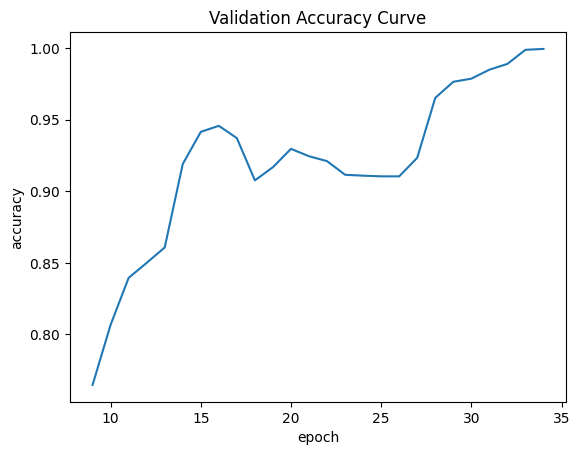

In [34]:
val_acc = pd.Series(history.history['val_accuracy']).rolling(10).mean()

plt.plot(val_acc)
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Validation Accuracy Curve")
#plt.yscale("log")
plt.show()

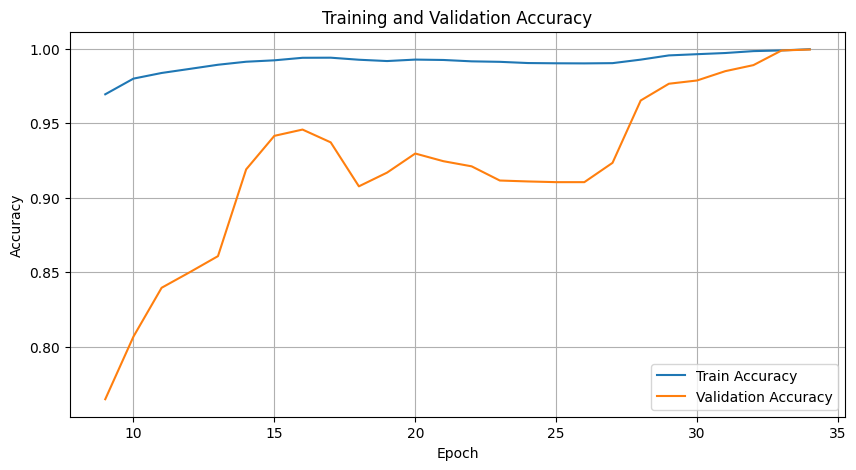

In [35]:
train_acc = pd.Series(history.history['accuracy']).rolling(window_size).mean()
val_acc   = pd.Series(history.history['val_accuracy']).rolling(window_size).mean()

plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Salvar o modelo
model_path = '/content/drive/MyDrive/AEROESPACIAIS/modelo_densenet_e100.h5'
model.save(model_path)

In [37]:
# Caminho do modelo em formato nativo Keras
model_path = '/content/drive/MyDrive/AEROESPACIAIS/modelo_densenet_e100.keras'

# Salvar modelo completo (arquitetura + pesos + otimizador)
model.save(model_path)

<a name='5'></a>
## 5. Predição e Avaliação

Agora que temos um modelo, vamos avaliá-lo usando nosso conjunto de teste. Podemos usar convenientemente a função `predict_generator` para gerar as previsões para as imagens em nosso conjunto de teste.

In [38]:
# Carregar o modelo
# model = tf.keras.models.load_model("modelos/MVP1_efficientnet/modelo_eficientnetv2s e100.h5")

In [39]:
# Avaliação no conjunto de teste
metrics = model.evaluate(test_ds, verbose=1)

print(f'Test loss: {metrics[0]:.4f}')
print(f'Test accuracy: {metrics[1]*100:.2f}%')


21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 764ms/step - accuracy: 1.0000 - loss: 3.5531e-04
Test loss: 0.0005
Test accuracy: 100.00%


In [40]:
# Lista das classes
class_names = ['A10', 'B1', 'B2', 'B52', 'C17', 'E3', 'F22', 'U2']

# --- 1. Obter rótulos verdadeiros e predições ---
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


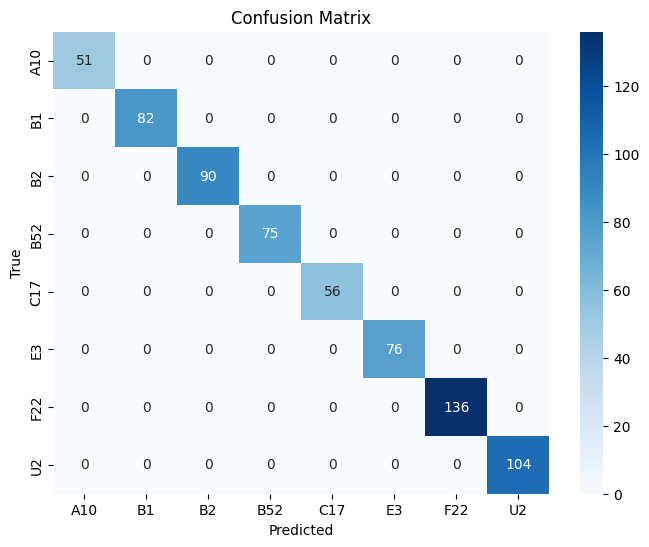

In [41]:
# --- 2. Matriz de Confusão ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# --- 3. Relatório de Classificação ---
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

         A10       1.00      1.00      1.00        51
          B1       1.00      1.00      1.00        82
          B2       1.00      1.00      1.00        90
         B52       1.00      1.00      1.00        75
         C17       1.00      1.00      1.00        56
          E3       1.00      1.00      1.00        76
         F22       1.00      1.00      1.00       136
          U2       1.00      1.00      1.00       104

    accuracy                           1.00       670
   macro avg       1.00      1.00      1.00       670
weighted avg       1.00      1.00      1.00       670



## Visualização

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


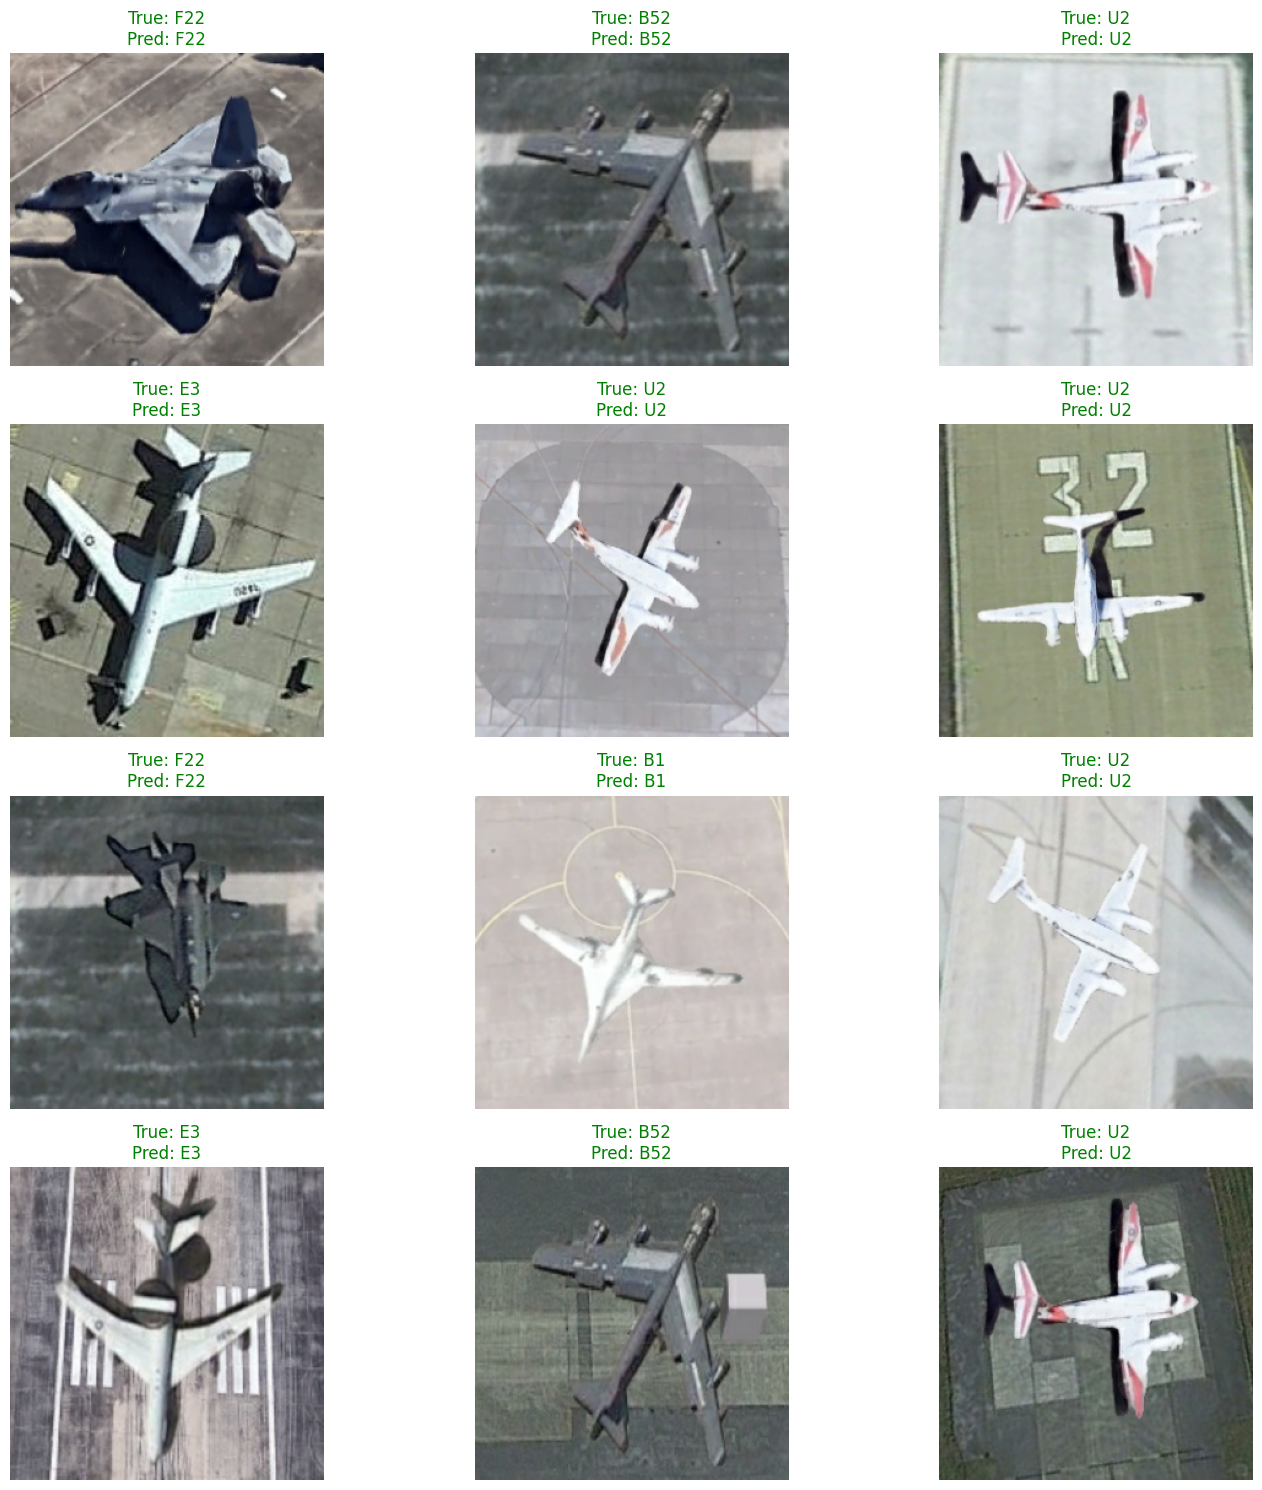

In [43]:
class_names = ['A10', 'B1', 'B2', 'B52', 'C17', 'E3', 'F22', 'U2']
plot_test_predictions_random(model, test_ds, class_names, num_images=12)